コード：Text Analysis & Feature Engineering with NLP  
https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d  
データセット：  
https://www.kaggle.com/rmisra/news-category-dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

# dict, list, set, および tuple に代わる、特殊なコンテナデータ型を実装できる。
import collections

# WordCloud用のライブラリ
# https://amueller.github.io/word_cloud/
import wordcloud

# 英語による自然言語処理をする上で役に立つ NLTK(Natural Language Toolkit)
# https://qiita.com/m__k/items/ffd3b7774f2fde1083fa
import nltk

## 中谷修代の言語検出ライブラリ（2014/03/03からのバージョン）のPythonへの移植。
## language-detection は指定されたテキストが何語か判定するJavaのライブラリ
import langdetect 

## TextBlob() 翻訳が可能
## TextBlob().sentiment.polarityで感情分析
## https://textblob.readthedocs.io/en/dev/quickstart.html
from textblob import TextBlob

# spaCy 自然言語用のライブラリ
# https://spacy.io/
#  実務で需要が多いと思われる以下の2タスクが可能
# https://qiita.com/moriyamanaoto/items/e98b8a6ff1c8fcf8e293
# 固有表現抽出
# フレーズ抽出
import spacy

# テキストや画像などの形式で構成されるデータセットから、機械学習アルゴリズムでサポートされている形式で特徴を抽出できる
# https://scikit-learn.org/stable/modules/feature_extraction.html
from sklearn import feature_extraction

# t-SNE [1]は、高次元データを視覚化するためのツールです。
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn import manifold

# このモジュールは、データセット/モデルのダウンロード、情報の取得、およびロードのためのAPIです。
# https://radimrehurek.com/gensim/downloader.html
import gensim.downloader as gensim_api

## 主にテキスト解析を対象としたスケーラブルな機械学習ライブラリで、Word2VecやDoc2VecをシンプルなAPIで利用することができる。
import gensim

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

In [2]:
lst_dics = []

In [3]:
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )     

In [4]:
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [5]:
dtf = pd.DataFrame(lst_dics)
display(dtf.head())
display(dtf.tail())

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


,category,headline,authors,link,short_description,date
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28
200852,SPORTS,Dwight Howard Rips Teammates After Magic Loss ...,,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...,2012-01-28


In [6]:
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
display(dtf.head())
display(dtf.tail())

,category,headline
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...


,category,headline
200844,TECH,Google+ Now Open for Teens With Some Safeguards
200845,TECH,Web Wars
200846,TECH,"First White House Chief Technology Officer, An..."
200847,TECH,Watch The Top 9 YouTube Videos Of The Week
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...


In [7]:
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
display(dtf.head())
display(dtf.tail())

,y,text
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...


,y,text
200844,TECH,Google+ Now Open for Teens With Some Safeguards
200845,TECH,Web Wars
200846,TECH,"First White House Chief Technology Officer, An..."
200847,TECH,Watch The Top 9 YouTube Videos Of The Week
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...


In [8]:
dtf.shape

(50879, 2)

In [9]:
# pythonの正規表現 https://docs.python.org/ja/3/library/re.html

# 正規表現で置換: re.sub()
# 第一引数に正規表現パターン、第二引数に置換先文字列、第三引数に処理対象の文字列を指定する。

# [] 文字の集合を指定するのに使います。集合の中では文字を個別に指定できます。 
# [amk] は 'a' 、 'm' または 'k' にマッチします。

# 集合の最初の文字が '^' なら、集合に 含まれない 全ての文字にマッチします。例えば、 [^5] は '5' を除くあらゆる文字にマッチ

# 'r' を前置した文字列リテラル内ではバックスラッシュが特別扱いされません。
# 従って "\n" が改行一文字からなる文字列であるのに対して、 r"\n" は '\' と 'n' の二文字からなる文字列です。
# 通常、 Python コード中では、パターンをこの raw 文字列記法を使って表現します。

# https://qiita.com/grrrr/items/7c8811b5cf37d700adc4
# \s 空白文字
# \w 単語構成文字:[a-zA-Z_0-9]

# まとめると r'[^\w\s]' --> 空白、アルファベット、数字ではない記号を含む

display(dtf[dtf["text"].str.contains(r'[^\s\w]')].head())
display(dtf[dtf["text"].str.contains(r'[^\s\w]')].tail())

,y,text
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...


,y,text
200839,ENTERTAINMENT,'Girl With the Dragon Tattoo' India Release Ca...
200843,TECH,Good Games -- Is It possible?
200844,TECH,Google+ Now Open for Teens With Some Safeguards
200846,TECH,"First White House Chief Technology Officer, An..."
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...


In [10]:
# r'[^\w\s] に HIT する --> ' が付いている
print(dtf["text"].iloc[0])
print(dtf["text"].iloc[2])

print()

# r'[^\w\s] に HIT しない --> ' が付いていない
print(dtf["text"].iloc[1])
print(dtf["text"].iloc[3])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork

Hugh Grant Marries For The First Time At Age 57
Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog


In [11]:
# sample()は重複なしの非復元抽出
dtf.sample(5)

,y,text
75543,POLITICS,Rand Paul Wants GOP To Join Black Lives Matter...
44751,POLITICS,America Thinks Donald Trump’s Debate Performan...
69936,POLITICS,HuffPost Rise: What You Need To Know On January 8
57817,POLITICS,Trump Campaign Rift Gets Personal
23692,POLITICS,Someone Trolled A GOP Senator By Signing Him U...


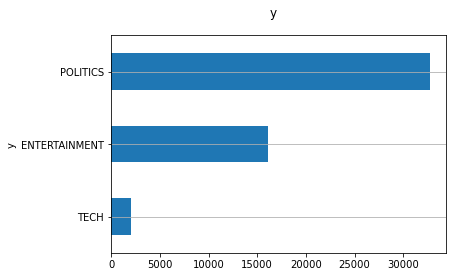

In [12]:
fig, ax = plt.subplots()

# subtitle() 中央揃えのタイトルを図に追加
fig.suptitle("y", fontsize=12)

dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='y')

plt.show()

In [13]:
display(dtf["y"].head())
display(dtf["y"].tail())

1    ENTERTAINMENT
2    ENTERTAINMENT
3    ENTERTAINMENT
4    ENTERTAINMENT
5    ENTERTAINMENT
Name: y, dtype: object

200844    TECH
200845    TECH
200846    TECH
200847    TECH
200848    TECH
Name: y, dtype: object

In [14]:
# count()だけだとトータルのカウント数しかでない。
dtf["y"].count()

50879

#### reset_index() で indexカラムを増やしてやらないと y カラムしかないので groupby() ができずエラーになる
dtf[x].groupby(x).count()

In [15]:
dtf["y"].reset_index().groupby("y").count()

,index
y,
ENTERTAINMENT,16058
POLITICS,32739
TECH,2082


In [16]:
dtf["y"].reset_index().groupby("y").count().sort_values(by= "index")

,index
y,
TECH,2082
ENTERTAINMENT,16058
POLITICS,32739


In [17]:
txt = dtf["text"].iloc[0]
txt

"Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song"

In [18]:
# 略語の意味 https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
print(txt, " --> ", langdetect.detect(txt))

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  en


In [19]:
# 両端（先頭、末尾）の文字を削除: strip()
dtf['lang'] = dtf["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
display(dtf.head())
display(dtf.tail())

,y,text,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en


,y,text,lang
200844,TECH,Google+ Now Open for Teens With Some Safeguards,en
200845,TECH,Web Wars,so
200846,TECH,"First White House Chief Technology Officer, An...",en
200847,TECH,Watch The Top 9 YouTube Videos Of The Week,en
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,en


In [20]:
# 英語(en)のみ抜粋
dtf = dtf[dtf["lang"]=="en"]

display(dtf.head())
display(dtf.tail())

,y,text,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en


,y,text,lang
200843,TECH,Good Games -- Is It possible?,en
200844,TECH,Google+ Now Open for Teens With Some Safeguards,en
200846,TECH,"First White House Chief Technology Officer, An...",en
200847,TECH,Watch The Top 9 YouTube Videos Of The Week,en
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,en


In [21]:
print("--- original ---")
print(txt)

print("--- cleaning ---")

# r'[^\w\s]' --> 空白、アルファベット、数字ではない記号を含む

txt = re.sub(r'[^\w\s]', '', str(txt).lower().strip())

print(txt)

print("--- tokenization ---")
txt = txt.split()
print(txt)

--- original ---
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
--- cleaning ---
will smith joins diplo and nicky jam for the 2018 world cups official song
--- tokenization ---
['will', 'smith', 'joins', 'diplo', 'and', 'nicky', 'jam', 'for', 'the', '2018', 'world', 'cups', 'official', 'song']


In [22]:
# ストップワード（ベクトル化してもしょうがない無意味な単語）の生成
# http://blog.livedoor.jp/oyajieng_memo/archives/2577889.html
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords[:5]
lst_stopwords[-6:-1]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kojis\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['weren', "weren't", 'won', "won't", 'wouldn']

In [23]:
# ストップワードの除外
print("--- remove stopwords ---")
txt = [word for word in txt if word not in lst_stopwords]

print(txt)

--- remove stopwords ---
['smith', 'joins', 'diplo', 'nicky', 'jam', '2018', 'world', 'cups', 'official', 'song']


### Stemming and Lemmatization  
https://jackee777.hatenablog.com/entry/2019/09/23/144818#:~:text=Lemmatization%20%E3%81%AF%E9%80%9A%E5%B8%B8%EF%BC%8C%E8%AA%9E%E5%BD%99%E3%82%84,%E3%81%A8%E3%81%97%E3%81%A6%E8%BF%94%E3%81%99%E3%81%93%E3%81%A8%E3%81%A7%E3%81%82%E3%82%8B%EF%BC%8E
Stemming は通常，ほとんどの場面で正しくなることを期待して単語の終端を切り落とすという粗くヒューリスティックな処理を指す（基本的に，派生的な接辞の除去も含む）．  

Lemmatization は通常，語彙や単語の形態素解析を利用して適切に操作することを指し，一般的に活用系の末尾のみの除去や基本形や辞書に存在する単語 lemma として返すことである．  

In [24]:
# 語幹の抽出 例：going --> go、unbelievable --> unbelieve
print("--- stemming ---")
ps = nltk.stem.porter.PorterStemmer()
print([ps.stem(word) for word in txt])

--- stemming ---
['smith', 'join', 'diplo', 'nicki', 'jam', '2018', 'world', 'cup', 'offici', 'song']


In [25]:
# Lemmaizisation/見出し語化とは、その単語を、辞書に載っている形に従って分類すること
# https://yottagin.com/?p=3218
# https://www.nltk.org/api/nltk.stem.html#nltk-stem-package
print("--- lemmatisation ---")
lem = nltk.stem.wordnet.WordNetLemmatizer()
nltk.download('wordnet')
print([lem.lemmatize(word) for word in txt])

[nltk_data] Downloading package wordnet to C:\Users\kojis\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- lemmatisation ---
['smith', 'join', 'diplo', 'nicky', 'jam', '2018', 'world', 'cup', 'official', 'song']


'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''

In [26]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    # x.join() ()内の文字列の配列を x で連結する "_".join(["a", "b", "c"]) --> "a_b_c"
    text = " ".join(lst_text)
    return text

In [27]:
dtf["text_clean"] = dtf["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [28]:
display(dtf.head())
display(dtf.tail())

,y,text,lang,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,morgan freeman devastated sexual harassment cl...


,y,text,lang,text_clean
200843,TECH,Good Games -- Is It possible?,en,good game possible
200844,TECH,Google+ Now Open for Teens With Some Safeguards,en,google open teen safeguard
200846,TECH,"First White House Chief Technology Officer, An...",en,first white house chief technology officer ane...
200847,TECH,Watch The Top 9 YouTube Videos Of The Week,en,watch top 9 youtube video week
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,en,rim ceo thorsten heins significant plan blackb...


In [29]:
print(dtf["text"].iloc[0], " --> ", dtf["text_clean"].iloc[0])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  smith join diplo nicky jam 2018 world cup official song


In [30]:
dtf['word_count'] = dtf["text"].apply(lambda x: len(str(x).split(" ")))
dtf['char_count'] = dtf["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
dtf['sentence_count'] = dtf["text"].apply(lambda x: len(str(x).split(".")))
dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
display(dtf.head())
display(dtf.tail())

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,smith join diplo nicky jam 2018 world cup offi...,14,62,1,4.428571,14.0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,hugh grant marries first time age 57,10,38,1,3.800000,10.0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,jim carrey blast castrato adam schiff democrat...,11,59,1,5.363636,11.0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,julianna margulies us donald trump poop bag pi...,13,59,1,4.538462,13.0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,morgan freeman devastated sexual harassment cl...,10,71,1,7.100000,10.0


,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
200843,TECH,Good Games -- Is It possible?,en,good game possible,6,24,1,4.000000,6.0
200844,TECH,Google+ Now Open for Teens With Some Safeguards,en,google open teen safeguard,8,40,1,5.000000,8.0
200846,TECH,"First White House Chief Technology Officer, An...",en,first white house chief technology officer ane...,10,60,1,6.000000,10.0
200847,TECH,Watch The Top 9 YouTube Videos Of The Week,en,watch top 9 youtube video week,9,34,1,3.777778,9.0
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,en,rim ceo thorsten heins significant plan blackb...,8,51,1,6.375000,8.0


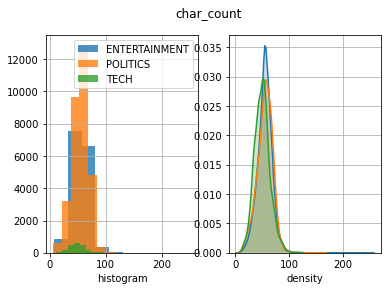

In [31]:
## char_count のグラフ
x, y = "char_count", "y"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in dtf[y].unique():
    sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(dtf[y].unique())
ax[1].grid(True)
plt.show()

In [32]:
# 特徴量とする dtf のカラム
column = "text"

dtf["sentiment"] = dtf[column].apply(lambda x: 
                   # TextBlob().sentiment.polarityで感情分析
                   TextBlob(x).sentiment.polarity)
display(dtf.head())
display(dtf.tail())

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,smith join diplo nicky jam 2018 world cup offi...,14,62,1,4.428571,14.0,0.000000
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,hugh grant marries first time age 57,10,38,1,3.800000,10.0,0.250000
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,jim carrey blast castrato adam schiff democrat...,11,59,1,5.363636,11.0,0.136364
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,julianna margulies us donald trump poop bag pi...,13,59,1,4.538462,13.0,0.000000
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,morgan freeman devastated sexual harassment cl...,10,71,1,7.100000,10.0,0.500000


,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
200843,TECH,Good Games -- Is It possible?,en,good game possible,6,24,1,4.000000,6.0,0.350000
200844,TECH,Google+ Now Open for Teens With Some Safeguards,en,google open teen safeguard,8,40,1,5.000000,8.0,0.000000
200846,TECH,"First White House Chief Technology Officer, An...",en,first white house chief technology officer ane...,10,60,1,6.000000,10.0,0.031481
200847,TECH,Watch The Top 9 YouTube Videos Of The Week,en,watch top 9 youtube video week,9,34,1,3.777778,9.0,0.500000
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,en,rim ceo thorsten heins significant plan blackb...,8,51,1,6.375000,8.0,0.375000


In [33]:
print(dtf["text"].iloc[0], " --> ", dtf["sentiment"].iloc[0])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  0.0


In [34]:
# 事前にコマンド python -m spacy download en_core_web_lg で ダウンロードする必要あり
# install後は開発環境を立ち上げなおしましょう
# https://stackoverflow.com/questions/56470403/spacy-nlp-spacy-loaden-core-web-lg
ner = spacy.load("en_core_web_lg")
## tag text
txt = dtf["text"].iloc[0]
doc = ner(txt)

## spaCy.displacy.render Jupyter環境で可視化
# https://qiita.com/moriyamanaoto/items/e98b8a6ff1c8fcf8e293
spacy.displacy.render(doc, style="ent")

In [35]:
# ner = spacy.load("en_core_web_lg")

# spacy.ents ドキュメント内の名前付きエンティティ。
# Span エンティティ認識機能が適用されている場合、名前付きエンティティオブジェクトのタプルを返します。
# https://bit.ly/32SRI5h

# .text   単語
# .label_ 単語のラベル
# .ents   固有表現
# 固有表現認識とは、テキストに出現する人名や地名などの固有名詞や、日付や時間などの数値表現を認識する技術のこと
# https://bit.ly/30JUk2C
dtf["tags"] = dtf["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] )

In [36]:
def utils_lst_count(lst):
    # listデータの各要素の出現回数を一括で取得できる。
    # https://note.nkmk.me/python-collections-counter/
    dic_counter = collections.Counter()
    # lst の要素をkeys、values が1の辞書データを作成
    for x in lst:
        dic_counter[x] += 1
        
    # OrderedDict() 順序付き辞書 https://note.nkmk.me/python-collections-ordereddict/
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

In [37]:
## count tags
dtf["tags"] = dtf["tags"].apply(lambda x: utils_lst_count(x))

In [38]:
## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

In [39]:
## extract features
tags_set = []

In [40]:
for lst in dtf["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])

In [41]:
tags_set = list(set(tags_set))

In [42]:
for feature in tags_set:
     dtf["tags_"+feature] = dtf["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))

In [43]:
display(dtf.head())
display(dtf.tail())

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags,tags_NORP,tags_LOC,tags_TIME,tags_ORG,tags_QUANTITY,tags_PERCENT,tags_DATE,tags_MONEY,tags_GPE,tags_LAW,tags_PRODUCT,tags_PERSON,tags_ORDINAL,tags_CARDINAL,tags_WORK_OF_ART,tags_LANGUAGE,tags_FAC,tags_EVENT
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,smith join diplo nicky jam 2018 world cup offi...,14,62,1,4.428571,14.0,0.000000,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,hugh grant marries first time age 57,10,38,1,3.800000,10.0,0.250000,"[{('Hugh Grant Marries For', 'PERSON'): 1}, {(...",0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,jim carrey blast castrato adam schiff democrat...,11,59,1,5.363636,11.0,0.136364,"[{('Jim Carrey Blasts', 'PERSON'): 1}, {('Cast...",1,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,julianna margulies us donald trump poop bag pi...,13,59,1,4.538462,13.0,0.000000,"[{('Julianna Margulies Uses', 'PERSON'): 1}]",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,morgan freeman devastated sexual harassment cl...,10,71,1,7.100000,10.0,0.500000,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags,tags_NORP,tags_LOC,tags_TIME,tags_ORG,tags_QUANTITY,tags_PERCENT,tags_DATE,tags_MONEY,tags_GPE,tags_LAW,tags_PRODUCT,tags_PERSON,tags_ORDINAL,tags_CARDINAL,tags_WORK_OF_ART,tags_LANGUAGE,tags_FAC,tags_EVENT
200843,TECH,Good Games -- Is It possible?,en,good game possible,6,24,1,4.000000,6.0,0.350000,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
200844,TECH,Google+ Now Open for Teens With Some Safeguards,en,google open teen safeguard,8,40,1,5.000000,8.0,0.000000,[{('Google+ Now Open for Teens With Some Safeg...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
200846,TECH,"First White House Chief Technology Officer, An...",en,first white house chief technology officer ane...,10,60,1,6.000000,10.0,0.031481,"[{('First White House', 'ORG'): 1}, {('Aneesh ...",0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
200847,TECH,Watch The Top 9 YouTube Videos Of The Week,en,watch top 9 youtube video week,9,34,1,3.777778,9.0,0.500000,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,en,rim ceo thorsten heins significant plan blackb...,8,51,1,6.375000,8.0,0.375000,"[{('RIM', 'ORG'): 1}, {('Thorsten Heins', 'PER...",0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


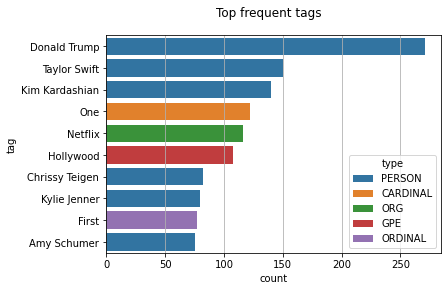

In [44]:
y = "ENTERTAINMENT"

top = 10
 
tags_list = dtf[dtf["y"]==y]["tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags", fontsize=12)

sns.barplot(x="count", y="tag", hue="type", 
            data=dtf_tags.iloc[:top,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

In [45]:
## predict wit NER
txt = dtf["text"].iloc[0]
entities = ner(txt).ents

In [46]:
## tag text
tagged_txt = txt
for tag in entities:
    tagged_txt = re.sub(tag.text, "_".join(tag.text.split()), 
                        tagged_txt) 
## show result
print(tagged_txt)

Will_Smith Joins Diplo And Nicky_Jam For The_2018_World_Cup's Official Song


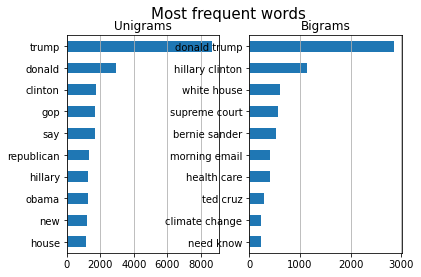

In [47]:
y = "POLITICS"
corpus = dtf[dtf["y"]==y]["text_clean"]

# Pythonシェルに移動し、次のように入力します。
# >>> import nltk
# >>> nltk.download()
# 次に、インストールウィンドウが表示されます。[モデル]タブに移動し、[識別子]列の下から[punkt]を選択します。
# 次に、[ダウンロード]をクリックすると、必要なファイルがインストールされます。その後、動作するはずです！
# https://stackoverflow.com/questions/4867197/failed-loading-english-pickle-with-nltk-data-load

lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)

## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)

## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [48]:
lst_words = ["box office", "republican", "apple"]
## count
lst_grams = [len(word.split(" ")) for word in lst_words]
vectorizer = feature_extraction.text.CountVectorizer(
                 vocabulary=lst_words, 
                 ngram_range=(min(lst_grams),max(lst_grams)))
dtf_X = pd.DataFrame(vectorizer.fit_transform(dtf["text_clean"]).todense(), columns=lst_words)

In [49]:
## add the new features as columns
dtf = pd.concat([dtf, dtf_X.set_index(dtf.index)], axis=1)
dtf.head()

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags,tags_NORP,tags_LOC,tags_TIME,tags_ORG,tags_QUANTITY,tags_PERCENT,tags_DATE,tags_MONEY,tags_GPE,tags_LAW,tags_PRODUCT,tags_PERSON,tags_ORDINAL,tags_CARDINAL,tags_WORK_OF_ART,tags_LANGUAGE,tags_FAC,tags_EVENT,box office,republican,apple
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,smith join diplo nicky jam 2018 world cup offi...,14,62,1,4.428571,14.0,0.000000,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,hugh grant marries first time age 57,10,38,1,3.800000,10.0,0.250000,"[{('Hugh Grant Marries For', 'PERSON'): 1}, {(...",0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,jim carrey blast castrato adam schiff democrat...,11,59,1,5.363636,11.0,0.136364,"[{('Jim Carrey Blasts', 'PERSON'): 1}, {('Cast...",1,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,julianna margulies us donald trump poop bag pi...,13,59,1,4.538462,13.0,0.000000,"[{('Julianna Margulies Uses', 'PERSON'): 1}]",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,morgan freeman devastated sexual harassment cl...,10,71,1,7.100000,10.0,0.500000,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


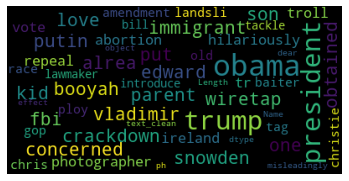

In [50]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [51]:
### glove-wiki-gigaword-300 とは？

### Gensim data
### https://bit.ly/303zEUh
### 実行すると376.1MBのデータのダウンロードが始まる

nlp = gensim_api.load("glove-wiki-gigaword-300")

In [52]:
word = "love"
nlp[word]

array([-4.5205e-01, -3.3122e-01, -6.3607e-02,  2.8325e-02, -2.1372e-01,
        1.6839e-01, -1.7186e-02,  4.7309e-02, -5.2355e-02, -9.8706e-01,
        5.3762e-01, -2.6893e-01, -5.4294e-01,  7.2487e-02,  6.6193e-02,
       -2.1814e-01, -1.2113e-01, -2.8832e-01,  4.8161e-01,  6.9185e-01,
       -2.0022e-01,  1.0082e+00, -1.1865e-01,  5.8710e-01,  1.8482e-01,
        4.5799e-02, -1.7836e-02, -3.3952e-01,  2.9314e-01, -1.9951e-01,
       -1.8930e-01,  4.3267e-01, -6.3181e-01, -2.9510e-01, -1.0547e+00,
        1.8231e-01, -4.5040e-01, -2.7800e-01, -1.4021e-01,  3.6785e-02,
        2.6487e-01, -6.6712e-01, -1.5204e-01, -3.5001e-01,  4.0864e-01,
       -7.3615e-02,  6.7630e-01,  1.8274e-01, -4.1660e-02,  1.5014e-02,
        2.5216e-01, -1.0109e-01,  3.1915e-02, -1.1298e-01, -4.0147e-01,
        1.7274e-01,  1.8497e-03,  2.4456e-01,  6.8777e-01, -2.7019e-01,
        8.0728e-01, -5.8296e-02,  4.0550e-01,  3.9893e-01, -9.1688e-02,
       -5.2080e-01,  2.4570e-01,  6.3001e-02,  2.1421e-01,  3.31

In [53]:
nlp[word].shape

(300,)

In [54]:
## find closest vectors
labels, X, x, y = [], [], [], []

## gensim.models.Word2Vec.most_similar()
## 上位N個の最も類似した単語を見つけます。
## https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
for t in nlp.most_similar(word, topn=20):
    X.append(nlp[t[0]])
    labels.append(t[0])

In [55]:
# t-SNE [1]は、高次元データを視覚化するためのツールです。
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# fit_transform()の使い方
# https://bunseki-train.com/t-sne-code-example/
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')

new_values = pca.fit_transform(X)
for value in new_values:
    x.append(value[0])
    y.append(value[1])

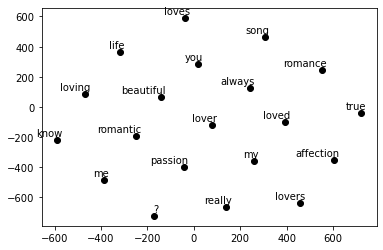

In [56]:
## plot
fig = plt.figure()
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="black")
    plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')

Text(5, 2, 'love')

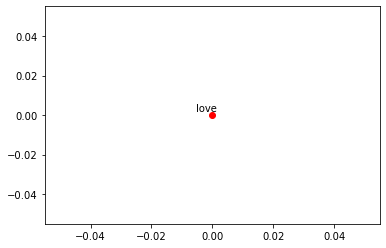

In [57]:
## add center
plt.scatter(x=0, y=0, c="red")

## .annotate() 矢印の描画
## https://qiita.com/haru1843/items/e85fe45163cd9763023c
plt.annotate(word, xy=(0,0), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

In [58]:
y = "TECH"
corpus = dtf[dtf["y"]==y]["text_clean"]

## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [59]:
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)

In [60]:
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

In [61]:
## LDA は1つの文書が複数のトピックから成ることを仮定した言語モデルの一種です。
## 日本語だと「潜在的ディリクレ配分法」と呼ばれます。単語などを表層的と表現するならば、トピックは単語と違って
## 表面には現れないので潜在的です。その潜在的な要素の分布の事前分布にディリクレ分布を仮定してごにょごにょするから
## 「潜在的ディリクレ配分法」と呼ぶのかなぁと思ってます。
## https://bit.ly/330iXuq

## gensim.models.ldamodel.LdaModel LDAモデル
## https://fits.hatenablog.com/entry/2018/03/13/214609

lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, 
                                            random_state=123, update_every=1, chunksize=100, 
                                            passes=10, alpha='auto', per_word_topics=True)

In [62]:
lst_dics = []
for i in range(0,3):
    # get_topics() 「トピック数×語彙数」の行列を返す。
    # http://kento1109.hatenablog.com/entry/2017/12/27/114811
    lst_tuples = lda_model.get_topic_terms(i)
    
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
        
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

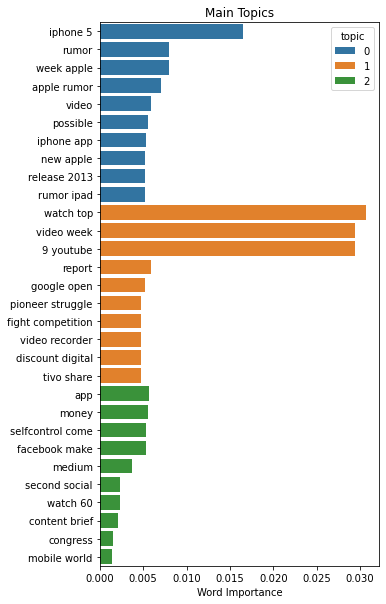

In [72]:
## グラフ
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()